# Experiments on Over-Sampling with APTOS 2019 dataset

This notebook has experiments conducted to explore the generality of the claims made in arxiv 2001.06296

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Importing libraries

In [2]:
import pandas as pd
import numpy as np

from fastai.vision import *

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

import os
from pathlib import Path
path = Path('/media/data/data archive/aptos/aptos2019-blindness-detection')
os.listdir(path)

['test.csv',
 'sample_submission.csv',
 'test_images',
 'train_images',
 'train.csv']

In [3]:
from fastai.metrics import error_rate

## Reading csv files and performing splits

In [4]:
test_df  = pd.read_csv(path/'test.csv')
train_df = pd.read_csv(path/'train.csv') 
sub      = pd.read_csv(path/'sample_submission.csv')

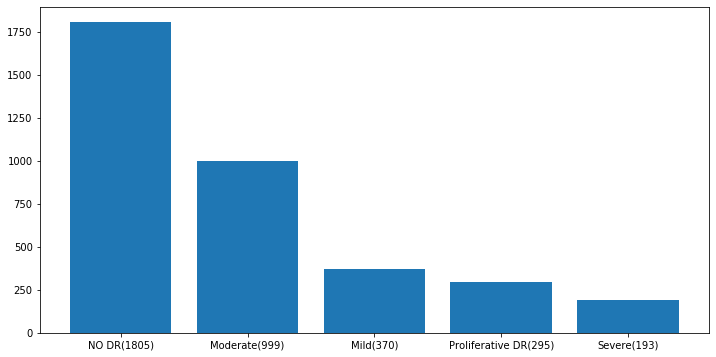

In [5]:
series = train_df.diagnosis.value_counts()
list_ = []
tup = ('NO DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR')
for val1, val2 in zip(series.index, series.values):
    list_.append(tup[val1])
    list_.append(val2)

legend = "{0}({1}),{2}({3}),{4}({5}),{6}({7}),{8}({9})".format(*list_)

plt.figure(figsize = (12,6))
plt.bar(legend.split(','), series.values);

### Note:
The histogram here shows how the data is unevenly ditributed across the 5 classes. The classes relate to the degree of diabetic retinopathy exhibited in a particular image. The degree of retinopathy can vary from 0-4 and is has the associated labels (NO DR (no diabetic retinopathy), Mild, Moderate, Severe, and Proliferative Diabetic Retinopathy)

### Splitting Data

FastAI has an interesting way of splitting data randomly. After shuffling, it assigns the first x% portion to the validation set, and then assigns the second (100-x%) portion to the training set. Note the the x% is specified in the range [0,1)

In [6]:
np.random.seed(17)
split = int(0.20 * train_df.shape[0])
train_df_rand = train_df.iloc[np.random.permutation([i for i in range(train_df.shape[0])])]
valid_rand = train_df_rand.iloc[:split]
# valid_rand.diagnosis.value_counts()

train_rand = train_df_rand.iloc[split:]
train_rand.shape, valid_rand.shape

((2930, 2), (732, 2))

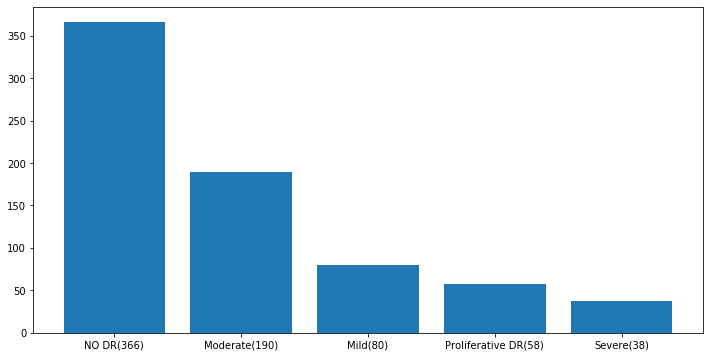

In [7]:
series = valid_rand.diagnosis.value_counts()
list_ = []
tup = ('NO DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR')

for val1, val2 in zip(series.index, series.values):
    list_.append(tup[val1])
    list_.append(val2)


legend = "{0}({1}),{2}({3}),{4}({5}),{6}({7}),{8}({9})".format(*list_)

plt.figure(figsize = (12,6))
plt.bar(legend.split(','), series.values);

### Note:
We can see that this split dataset is a good representation of the population of the complete dataset. It retains most of the population characteristics of the total train set.

## Normal dataset

This dataset is used as is. Without any oversampling technique applied and nothing else done to it except TTA.

In [9]:
np.random.seed(17)
data = (ImageList.from_df(train_df, path = path/'train_images', suffix='.png')
                 .split_by_rand_pct(0.2)
                 .label_from_df()
                 .transform(tfms=get_transforms(), size=224)
                 .databunch(bs=32)
                 .normalize(imagenet_stats))

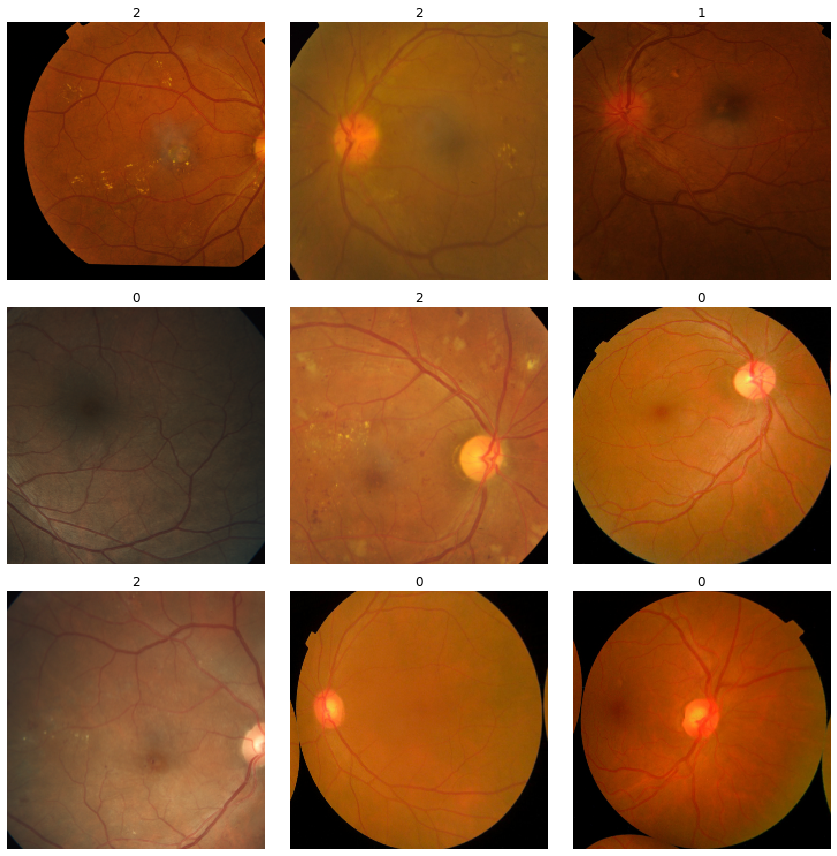

In [10]:
data.show_batch(rows=3)

In [11]:
data.classes

[0, 1, 2, 3, 4]

In [12]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


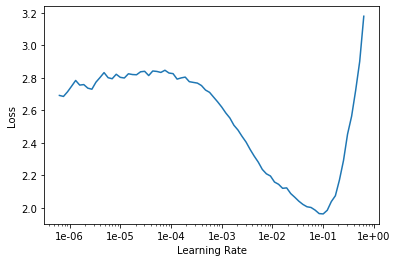

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.311066,0.840724,0.284153,01:49
1,0.899008,0.681517,0.219945,01:25
2,0.721459,0.629017,0.203552,01:25
3,0.590816,0.543601,0.206284,01:25
4,0.512097,0.546907,0.195355,01:25


In [15]:
learn.save('norm_model34-1')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


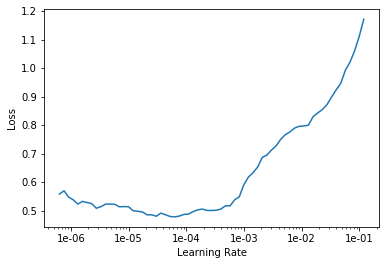

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.531843,0.571386,0.200820,01:26
1,0.497787,0.533231,0.199454,01:25
2,0.485640,0.541876,0.196721,01:26


In [18]:
learn.save('norm_model34-2')

## The bad oversampling

This is the dataset that is based on the bad form of oversampling. That is, oversampling before partitioning data.

In [20]:
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state =17)

In [21]:
x_over, y_over = oversampler.fit_resample(train_df.iloc[:,0].values.reshape(-1,1), train_df.iloc[:,1].values)
over_df = pd.DataFrame()
over_df = over_df.assign(files = x_over.squeeze())
over_df = over_df.assign(labels = y_over)

### Why bad?

In [22]:
#let's do a random split and then see how many files are common for the two resulting dataframes.

np.random.seed(17)

indexes = np.random.permutation([i for i in range(over_df.shape[0])])
# print(indexes[:5])
over_split = int(0.8 * over_df.shape[0])

split_train   = over_df.iloc[indexes[:over_split]]
split_valid = over_df.iloc[indexes[over_split:]]

files_train   = set(split_train.files.unique().tolist())
files_valid   = set(split_valid.files.unique().tolist())

common_files = files_train.intersection(files_valid)
print(f'number of common files are {len(common_files)}')

contamination_count = split_valid.files.value_counts().loc[list(common_files)].values.sum()
print(f'this represents a test contamination of {100*contamination_count/split_valid.shape[0]:.2f}%')
print(f'which represents a contamination of {100*len(common_files)/train_df.shape[0]:.2f}% not accounting for duplicates')

number of common files are 822
this represents a test contamination of 73.63%
which represents a contamination of 22.45% not accounting for duplicates


### Training with bad data

In [24]:
np.random.seed(17)
data_bad = (ImageList.from_df(over_df, path = path/'train_images', suffix='.png')
                     .split_by_rand_pct(0.2)
                     .label_from_df()
                     .transform(tfms=get_transforms(), size=224)
                     .databunch(bs=32)
                     .normalize(imagenet_stats))

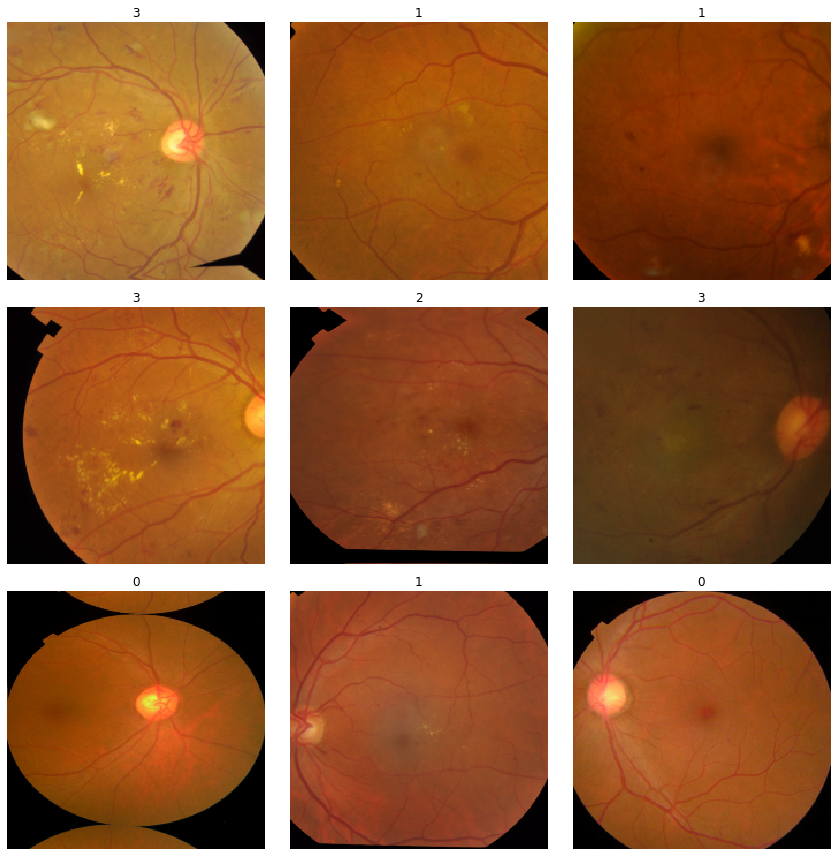

In [25]:
data_bad.show_batch(rows=3)

In [26]:
learn_bad = cnn_learner(data_bad, models.resnet34, pretrained=True, metrics=[accuracy,error_rate])

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


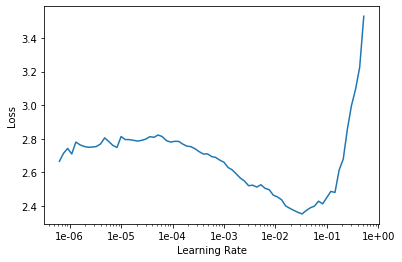

In [27]:
learn_bad.lr_find()
learn_bad.recorder.plot()

In [28]:
learn_bad.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.586596,0.915854,0.660388,0.339612,04:16
1,1.092247,0.687317,0.751801,0.248199,04:12
2,0.821169,0.562942,0.785596,0.214404,04:15
3,0.733904,0.490189,0.815512,0.184488,04:16
4,0.690773,0.480498,0.821053,0.178947,04:13


In [29]:
learn_bad.save('bad_model34-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


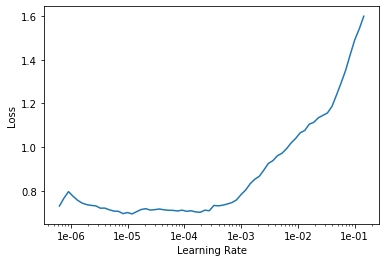

In [30]:
learn_bad.unfreeze()
learn_bad.lr_find()
learn_bad.recorder.plot()

In [31]:
learn_bad.fit_one_cycle(3, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.673398,0.438763,0.855402,0.144598,04:14
1,0.517198,0.316115,0.903047,0.096953,04:13
2,0.418875,0.293397,0.901385,0.098615,04:14


In [32]:
learn_bad.save('bad_model34-2')

## Proper Oversampling

In this version, we oversample only the train data and do it only after splitting into train and validation to ensure that there are no duplicates. 

In [34]:
x_over, y_over = oversampler.fit_resample(train_rand.iloc[:,0].values.reshape(-1,1), train_rand.iloc[:,1].values)
train_over = pd.DataFrame()
train_over = train_over.assign(files = x_over.squeeze())
train_over = train_over.assign(labels = y_over)

In [35]:
train_over.shape, valid_rand.shape

((7195, 2), (732, 2))

In [36]:
train_over.labels.value_counts()

3    1439
2    1439
1    1439
4    1439
0    1439
Name: labels, dtype: int64

In [37]:
valid_rand.diagnosis.value_counts()

0    366
2    190
1     80
4     58
3     38
Name: diagnosis, dtype: int64

### Note:
You can see that the population characteristics are retained in this validation set.

In [38]:
files_train   = set(train_over.files.unique().tolist())
files_valid   = set(valid_rand.iloc[:,0].unique().tolist())

common_files = files_train.intersection(files_valid)
print(f'number of common files are {len(common_files)}')

contamination_count = valid_rand.iloc[:,0].value_counts().loc[list(common_files)].values.sum()
print(f'this represents a test contamination of {100*contamination_count/valid_rand.shape[0]:.2f}%')

number of common files are 0
this represents a test contamination of 0.00%


In [39]:
train_list = ImageList.from_df(df = train_over, path = path/'train_images', suffix='.png')
valid_list = ImageList.from_df(df = valid_rand, path = path/'train_images', suffix='.png')

In [40]:
sd = train_list.split_by_list(train = train_list, valid= valid_list)

In [41]:
# Calling seed() to ensure reproducibilty.
np.random.seed(17)

#Here's what we need!
data_proper = (sd.label_from_df()
                .transform(tfms=get_transforms(), size = 224)
                .databunch(bs=32)
                .normalize(imagenet_stats))

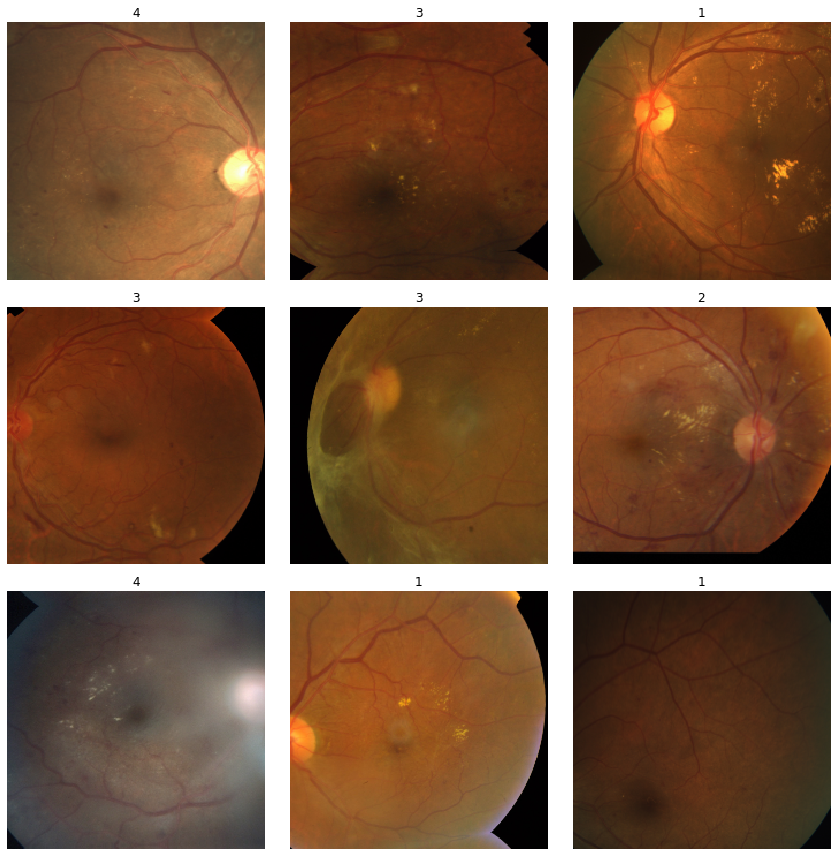

In [42]:
data_proper.show_batch(rows=3)

In [43]:
learn_proper = cnn_learner(data_proper, models.resnet34, pretrained=True, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


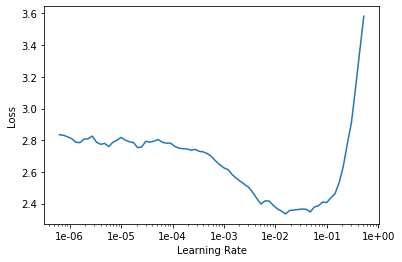

In [44]:
learn_proper.lr_find()
learn_proper.recorder.plot()

In [45]:
learn_proper.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.404229,0.960632,0.311475,03:38
1,0.918601,0.624171,0.255464,03:40
2,0.744743,0.624166,0.226776,03:41
3,0.576424,0.580243,0.209016,03:44
4,0.495704,0.555990,0.193989,03:38


In [46]:
learn_proper.save('prop_model34-1')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


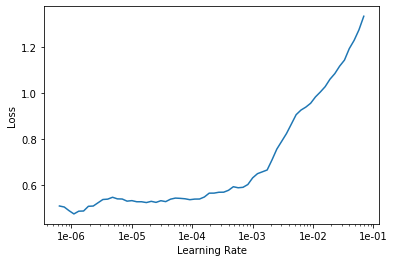

In [47]:
learn_proper.unfreeze()
learn_proper.lr_find()
learn_proper.recorder.plot()

In [48]:
learn_proper.fit_one_cycle(3, slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.455045,0.561539,0.189891,03:37
1,0.401427,0.574944,0.198087,03:36
2,0.373707,0.578379,0.191257,03:37


In [49]:
learn_proper.save('prop_model34-2')

## Proper oversampling - Real validation set - mixup

We use mixup to see any difference in performance on a train only oversampling

In [51]:
learn_proper_mix = cnn_learner(data_proper, models.resnet34, pretrained=True, metrics=[accuracy, error_rate]).mixup()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


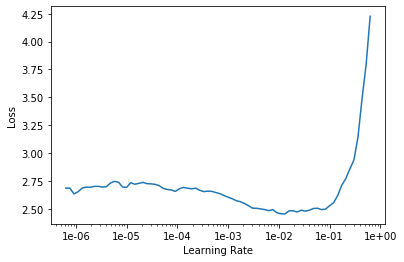

In [52]:
learn_proper_mix.lr_find()
learn_proper_mix.recorder.plot()

In [53]:
learn_proper_mix.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.911651,0.932955,0.654372,0.345628,03:39
1,1.578729,0.812842,0.688525,0.311475,03:37
2,1.320900,0.736274,0.706284,0.293716,03:38
3,1.124571,0.657770,0.744536,0.255464,03:37
4,1.050011,0.602220,0.775956,0.224044,03:37
5,1.020624,0.624073,0.765027,0.234973,03:36
6,0.942076,0.609397,0.778689,0.221311,03:38
7,0.927759,0.594800,0.778689,0.221311,03:37
8,0.907099,0.592382,0.775956,0.224044,03:41
9,0.936482,0.584289,0.796448,0.203552,03:37


In [54]:
learn_proper_mix.save('prop_mix_model34-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


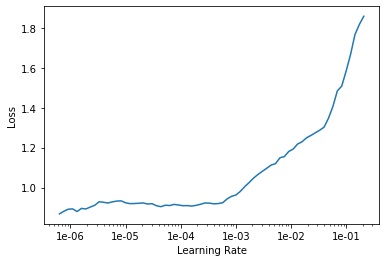

In [55]:
learn_proper_mix.unfreeze()
learn_proper_mix.lr_find()
learn_proper_mix.recorder.plot()

In [56]:
learn_proper_mix.fit_one_cycle(6, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.880560,0.583194,0.780055,0.219945,03:37
1,0.851882,0.598251,0.782787,0.217213,03:36
2,0.777417,0.595419,0.793716,0.206284,03:39
3,0.726298,0.618853,0.793716,0.206284,03:43
4,0.712614,0.591938,0.792350,0.207650,03:43
5,0.676326,0.584872,0.804645,0.195355,03:40


In [58]:
learn_proper_mix.save('prop_mix_model34-2')

## Original data - mixup

We also use mixup on the original dataset to see what happens.

In [59]:
learn_mix = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy, error_rate]).mixup()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


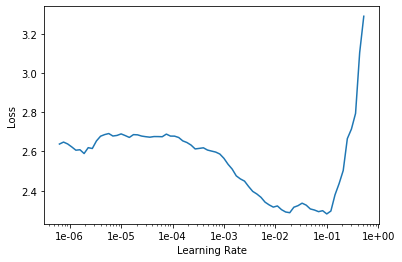

In [60]:
learn_mix.lr_find()
learn_mix.recorder.plot()

In [61]:
learn_mix.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.732339,0.804221,0.743169,0.256831,01:24
1,1.383073,0.795734,0.721311,0.278689,01:25
2,1.109894,0.643036,0.777322,0.222678,01:25
3,0.937152,0.633850,0.766393,0.233607,01:29
4,0.894232,0.658375,0.748634,0.251366,01:28
5,0.854295,0.552779,0.801913,0.198087,01:28
6,0.824595,0.501620,0.819672,0.180328,01:26
7,0.789229,0.495110,0.833333,0.166667,01:24
8,0.777322,0.485539,0.831967,0.168033,01:26
9,0.747576,0.485824,0.826503,0.173497,01:25


In [62]:
learn_mix.save('norm_mix_model34-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


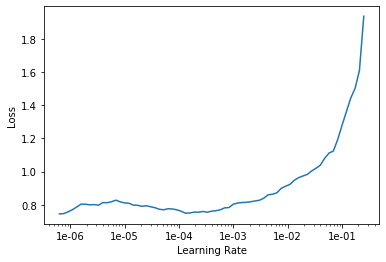

In [63]:
learn_mix.unfreeze()
learn_mix.lr_find()
learn_mix.recorder.plot()

In [64]:
learn_mix.fit_one_cycle(6, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.743902,0.484564,0.829235,0.170765,01:26
1,0.754893,0.496413,0.830601,0.169399,01:24
2,0.724672,0.485255,0.827869,0.172131,01:28
3,0.703917,0.484692,0.821038,0.178962,01:27
4,0.677392,0.472799,0.833333,0.166667,01:25
5,0.670412,0.477862,0.829235,0.170765,01:25


In [65]:
learn_mix.save('norm_mix_model34-2')

## Interpretations

### Original dataset

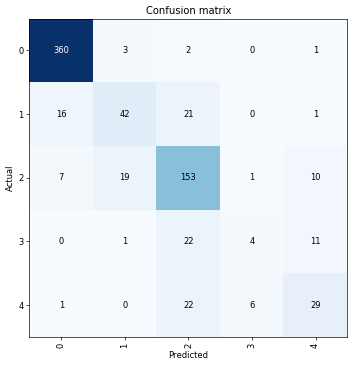

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### With oversampling on data before split

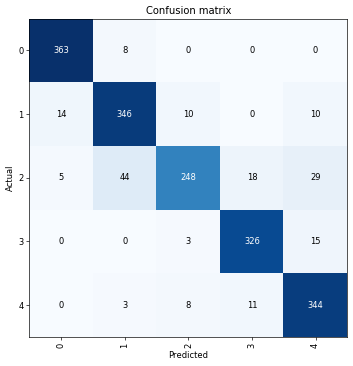

In [33]:
interp = ClassificationInterpretation.from_learner(learn_bad)

losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### With oversampling on train 

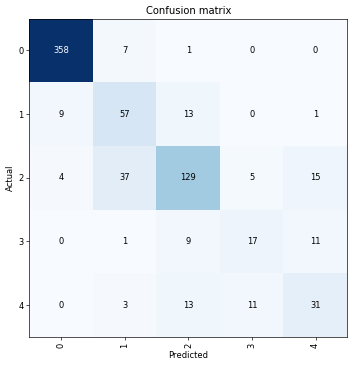

In [50]:
interp = ClassificationInterpretation.from_learner(learn_proper)

losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### With mixup, oversampling on train and original validation

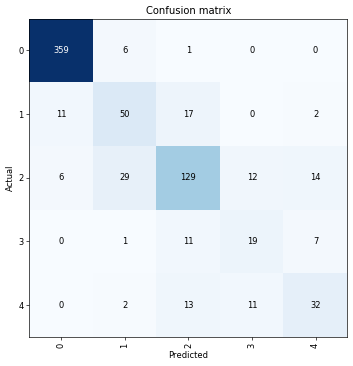

In [57]:
interp = ClassificationInterpretation.from_learner(learn_proper_mix)

losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### With mixup on original dataset

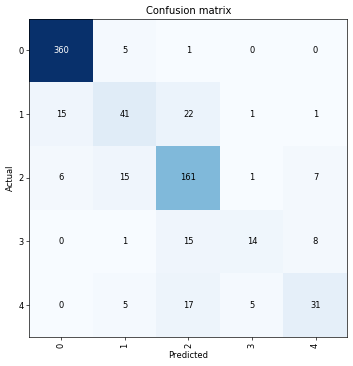

In [66]:
interp = ClassificationInterpretation.from_learner(learn_mix)

losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)